### Decision Tree Regressor model

#### on convoluted rgb data

In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import tensorflow as tf
from sklearn.linear_model import RidgeCV
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
import seaborn as sns

In [2]:
%%time
# preprocess: data import, shuffle, switch axes, flattening , convolution. detailed in notebk 'rgb_data_load_mod.ipynb'.

b = np.load('../Downloads/depth_training_data.npz')
data_rgb = b['rgb_images']                # RGB DATA 
data_depth = b['depth_maps']              # DEPTH DATA 
data_rgb = data_rgb/255
data_depth = data_depth - data_depth.min()
# switch axes for plotting
data_rgb = data_rgb.transpose(0,2,3,1)
data_depth = data_depth.transpose(0,2,3,1)

# shuffle images
random.seed(400)
random.shuffle(data_depth)     # inplace method
random.seed(400)
random.shuffle(data_rgb)

# change to 32 bit floats
data_rgb = data_rgb.astype(np.float32)       # size(type) modification for nn 
data_depth = data_depth.astype(np.float32)

data_rgb, data_depth = data_rgb[:1400], data_depth[:1400]

# flatten
X = data_rgb.reshape(data_rgb.shape[0],27648)        
Y = data_depth.reshape(data_depth.shape[0],9216)
#conv
input_shape = data_rgb.shape
x = data_rgb  # no padding, strides default
y = tf.keras.layers.Conv2D(128, 3, activation='relu', input_shape=input_shape[1:])(x)
x_f = tf.keras.layers.MaxPool2D()(y)
x_f.shape
y1 = tf.keras.layers.Conv2D(96, 3, activation='relu')(x_f)
y1.shape
x_ff = tf.keras.layers.MaxPool2D()(y1)
x_ff.shape
y11 = tf.keras.layers.Conv2D(96, 3, activation='relu')(x_ff)
y11.shape
x_fff = tf.keras.layers.MaxPool2D()(y11)
x_fff.shape
x_fff = tf.keras.layers.GlobalAveragePooling2D()(x_fff) 

xconv = x_fff.numpy()

2022-01-05 16:19:16.912753: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 38.3 s, sys: 1min 2s, total: 1min 41s
Wall time: 1min 17s


In [3]:
xconv.shape # selected 96 features from 96*96*3

(1400, 96)

#### splitting test train 

In [3]:
x_train, x_test, y_train, y_test = train_test_split(xconv, Y, test_size= 0.20, random_state = 0)

#### RForest : hyper params (estimators = 500, max leaf nodes = 16)

In [5]:
%%time
rf=RandomForestRegressor(n_estimators=500,max_leaf_nodes=16,n_jobs=-1,oob_score=True)

rfModel=rf.fit(x_train, y_train)

y_pred=rfModel.predict(x_test)

mse = mean_squared_error(y_pred,y_test)
print(f"model mse is {mse :3.2}")
print(f"The Out-of- bag score: {rfModel.oob_score_}:3.5")
oob_prex = rfModel.oob_prediction_

model mse is 0.0042
The Out-of- bag score: 0.7889306592396872:3.5
CPU times: user 51min 54s, sys: 8.45 s, total: 52min 3s
Wall time: 13min 28s


In [6]:
rfModel.feature_importances_ # not important, images can be deep anywhere 

array([4.84359235e-03, 2.48729543e-02, 3.27371787e-03, 1.79968085e-03,
       5.37152751e-03, 2.28336338e-03, 2.63264100e-02, 1.57417761e-02,
       0.00000000e+00, 4.82714060e-04, 1.43192824e-02, 1.74376528e-03,
       1.24426007e-03, 1.29082083e-03, 1.52003083e-03, 1.06263875e-03,
       1.95118781e-03, 1.16470871e-04, 0.00000000e+00, 1.78410041e-03,
       2.12527709e-02, 1.22334692e-02, 0.00000000e+00, 2.78138181e-01,
       4.84011841e-03, 3.56310874e-03, 2.29629502e-05, 5.98932420e-04,
       1.15646056e-04, 2.79772297e-03, 8.58950388e-02, 4.49746229e-04,
       1.19787343e-02, 2.81866761e-04, 2.87482692e-03, 2.85418139e-03,
       2.65217952e-03, 0.00000000e+00, 3.92948087e-03, 1.75581398e-01,
       4.12789379e-03, 3.80191962e-03, 3.97099059e-02, 4.64923092e-03,
       1.25879615e-04, 8.17536418e-04, 7.87959180e-03, 7.12849842e-04,
       2.45228559e-04, 2.86479537e-03, 2.98542711e-03, 4.70234897e-03,
       1.43640345e-02, 5.71687530e-05, 9.88846843e-03, 1.34047435e-03,
      

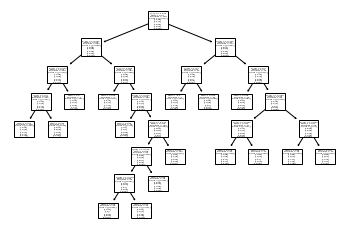

In [7]:
for i in rfModel.estimators_:
    plot_tree(i)

####  hyper params (estimators=1000,max_leaf_nodes=16,min_samples_leaf=5,max_depth=10)

In [8]:
%%time
rf=RandomForestRegressor(n_estimators=1000,max_leaf_nodes=16,min_samples_leaf=5,max_depth=10,n_jobs=-1,oob_score=True)

rfModel1=rf.fit(x_train, y_train)

y_pred1=rfModel1.predict(x_test)

mse = mean_squared_error(y_pred1,y_test)
print(f"model mse is {mse :3.2}")
print(f"The Out-of- bag score: {rfModel1.oob_score_}:3.5")
oob_prex1 = rfModel1.oob_prediction_

model mse is 0.0043
The Out-of- bag score: 0.7768405948255107:3.5
CPU times: user 1h 36min 5s, sys: 18.6 s, total: 1h 36min 24s
Wall time: 25min 4s


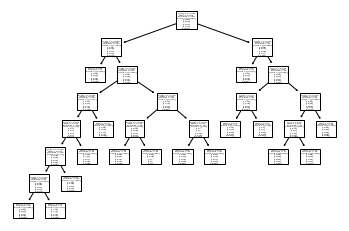

In [10]:
for i in rfModel1.estimators_:
    plot_tree(i)

#### decision tree : hyper params (estimators=600,max_leaf_nodes=16,min_samples_leaf=5,max_depth=15)

In [11]:
%%time
rf=RandomForestRegressor(n_estimators=600,max_leaf_nodes=16,min_samples_leaf=5,max_depth=15,n_jobs=-1,oob_score=True)

rfModel2=rf.fit(x_train, y_train)

y_pred2=rfModel2.predict(x_test)

mse = mean_squared_error(y_pred2,y_test)
print(f"model mse is {mse :3.2}")
print(f"The Out-of- bag score: {rfModel2.oob_score_}:3.5")
oob_prex2 = rfModel2.oob_prediction_

model mse is 0.0043
The Out-of- bag score: 0.7770459359077722:3.5
CPU times: user 57min 57s, sys: 10.8 s, total: 58min 7s
Wall time: 15min 10s


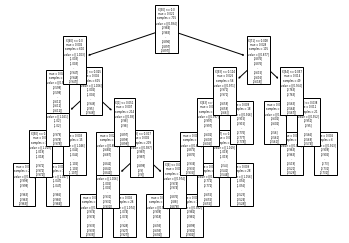

In [12]:
for i in rfModel2.estimators_:
    plot_tree(i)

#### decision tree : hyper params (estimators=400,max_leaf_nodes=32,min_samples_leaf=4,max_depth=20)

In [13]:
%%time
rf=RandomForestRegressor(n_estimators=400,max_leaf_nodes=32,min_samples_leaf=4,max_depth=20,n_jobs=-1,oob_score=True)

rfModel3=rf.fit(x_train, y_train)

y_pred3=rfModel3.predict(x_test)

mse = mean_squared_error(y_pred3,y_test)
print(f"model mse is {mse :3.2}")
print(f"The Out-of- bag score: {rfModel3.oob_score_}:3.5")
oob_prex3 = rfModel3.oob_prediction_

model mse is 0.0031
The Out-of- bag score: 0.828743764880539:3.5
CPU times: user 48min 18s, sys: 9.14 s, total: 48min 27s
Wall time: 12min 46s


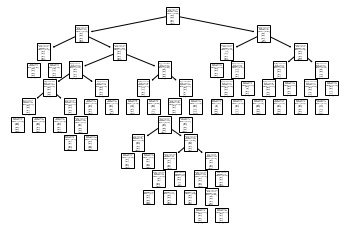

In [13]:
for i in rfModel3.estimators_:
    plot_tree(i)

#### We find that mse does not change after changing estimator and other params. 

#### Plotting images with least complex model, rfModel3 with 400 estimators 

In [6]:
print("<storing color img data for comparison>")
colorimg_train, colorimg_test = train_test_split(data_rgb, test_size= 0.20, random_state = 0)

<storing color img data for comparison>


#### Plotting with best model w/ estimators =400, leaf_nodes=32, min_samples_leaf= 4, max_depth=20

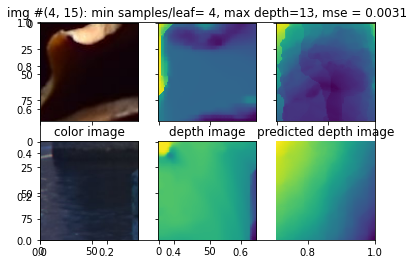

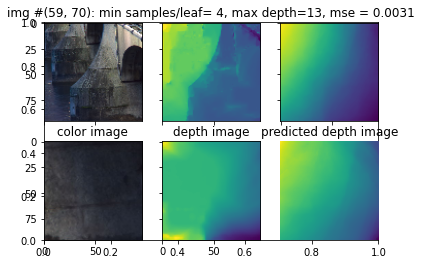

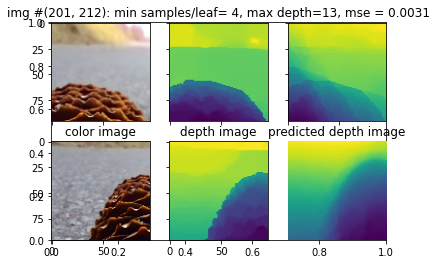

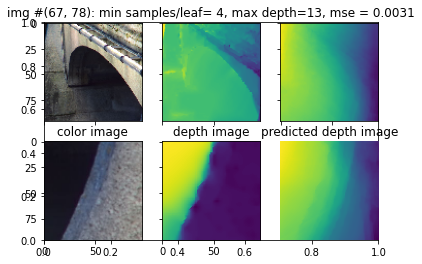

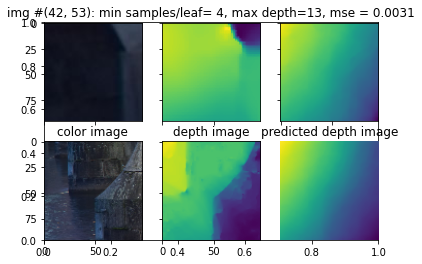

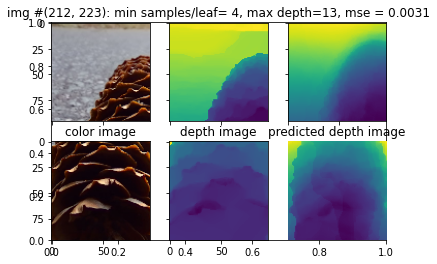

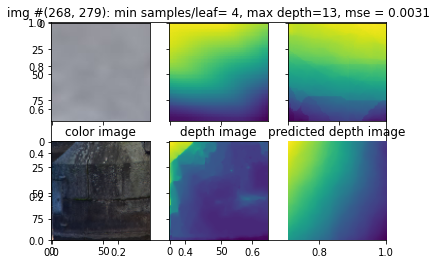

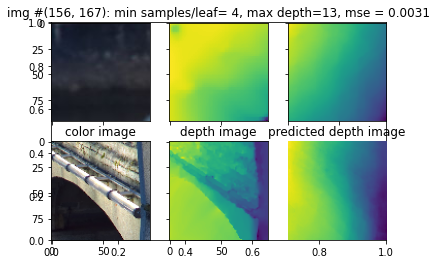

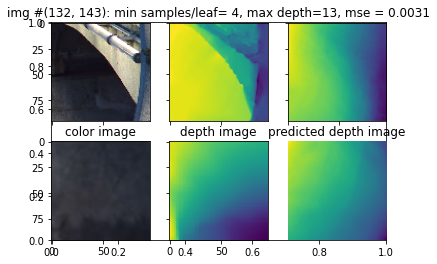

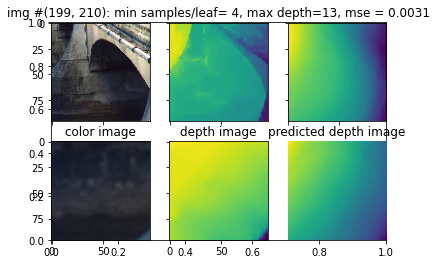

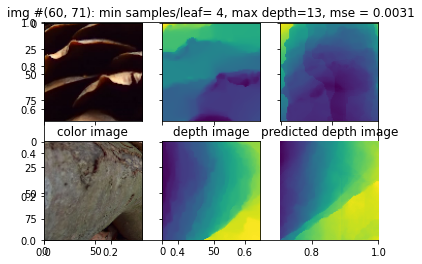

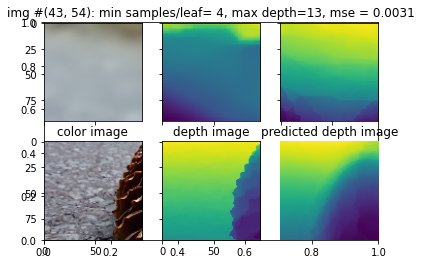

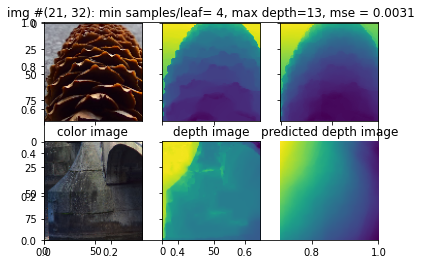

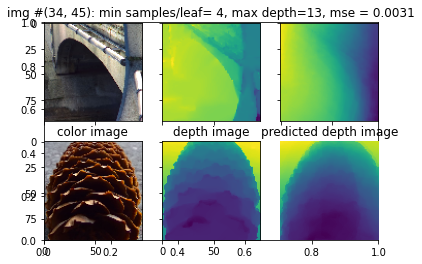

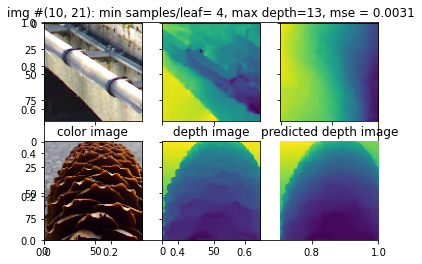

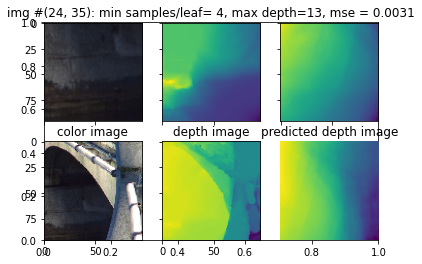

In [18]:
images = [4,59,201,67,42, 212, 268, 156, 132, 199,60,43,21,34,10,24]
for k in images:
    f = plt.figure()
    plt.title(f"img #{k,k+11}: min samples/leaf= 4, max depth=13, mse = {mse :3.2}")
    axarr = f.subplots(2,3)
    plt.axis("off")
    axarr[0,0].imshow(colorimg_test[k])
    axarr[0,1].imshow(y_test[k].reshape(96,96,1))
    axarr[0,2].imshow(y_pred3[k].reshape(96,96,1))
    axarr[1,0].imshow(colorimg_test[k+11])
    axarr[1,1].imshow(y_test[k+11].reshape(96,96,1))
    axarr[1,2].imshow(y_pred3[k+11].reshape(96,96,1))
    axarr[1,0].set_title('color image')
    axarr[1,1].set_title('depth image')
    axarr[1,2].set_title('predicted depth image')
    for ax in axarr.flat:
        ax.label_outer()

#### Further reducing # of trees in Forest to 300

In [19]:
%%time
rf=RandomForestRegressor(n_estimators=300,max_leaf_nodes=32,min_samples_leaf=4,max_depth=20,n_jobs=-1,oob_score=True)

rfModel3=rf.fit(x_train, y_train)

y_pred3=rfModel3.predict(x_test)

mse = mean_squared_error(y_pred3,y_test)
print(f"model mse is {mse :3.2}")
print(f"The Out-of- bag score: {rfModel3.oob_score_}:3.5")
oob_prex3 = rfModel3.oob_prediction_

model mse is 0.0031
The Out-of- bag score: 0.8274782515712766:3.5
CPU times: user 36min 33s, sys: 8.04 s, total: 36min 41s
Wall time: 9min 47s


MSE and OOB score are same as prev model. Computation time betters. Now changing other hyperparams and reducing estimators.

In [20]:
%%time
rf=RandomForestRegressor(n_estimators=200,max_leaf_nodes=64,min_samples_leaf=4,max_depth=20,n_jobs=-1,oob_score=True)

rfModel5=rf.fit(x_train, y_train)

y_pred5=rfModel5.predict(x_test)

mse = mean_squared_error(y_pred5,y_test)
print(f"model mse is {mse :3.2}")
print(f"The Out-of- bag score: {rfModel5.oob_score_}:3.5")
oob_prex5 = rfModel5.oob_prediction_

model mse is 0.0027
The Out-of- bag score: 0.8490380632961082:3.5
CPU times: user 28min 17s, sys: 5.21 s, total: 28min 22s
Wall time: 7min 28s


#### Default model w/ estimators =100

In [8]:
%%time
rf=RandomForestRegressor(max_leaf_nodes=64,min_samples_leaf=4,max_depth=20,n_jobs=-1,oob_score=True)

rfModel6=rf.fit(x_train, y_train)

y_pred6=rfModel6.predict(x_test)

mse = mean_squared_error(y_pred6,y_test)
print(f"model mse is {mse :3.2}")
print(f"The Out-of- bag score: {rfModel6.oob_score_:3.5}")
oob_prex6 = rfModel6.oob_prediction_

model mse is 0.0032
The Out-of- bag score: 0.84961
CPU times: user 16min 16s, sys: 2.6 s, total: 16min 19s
Wall time: 4min 15s


#### reducing estimators (trees in forest) to 50

In [4]:
%%time
rf=RandomForestRegressor(n_estimators=50, max_leaf_nodes=64,min_samples_leaf=4,max_depth=20,n_jobs=-1,oob_score=True)

rfModel7=rf.fit(x_train, y_train)

y_pred7=rfModel7.predict(x_test)

mse = mean_squared_error(y_pred7,y_test)
print(f"model mse is {mse :3.2}")
print(f"The Out-of- bag score: {rfModel7.oob_score_:3.5}")
oob_prex7 = rfModel7.oob_prediction_

model mse is 0.0032
The Out-of- bag score: 0.83745
CPU times: user 8min 10s, sys: 1.54 s, total: 8min 12s
Wall time: 2min 13s


#### Plotting using estimators as 100, model 6

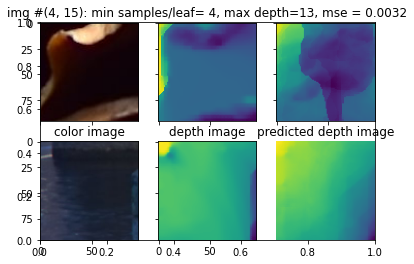

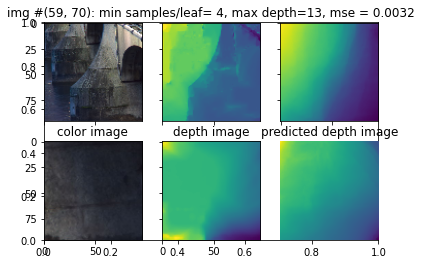

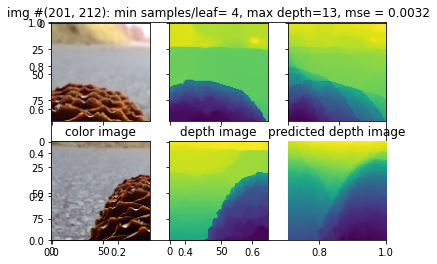

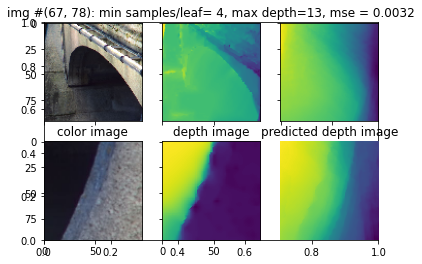

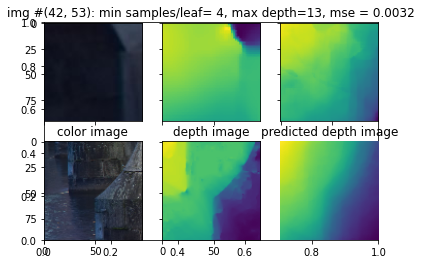

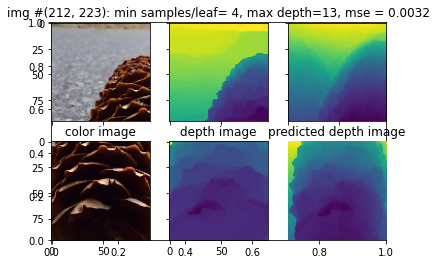

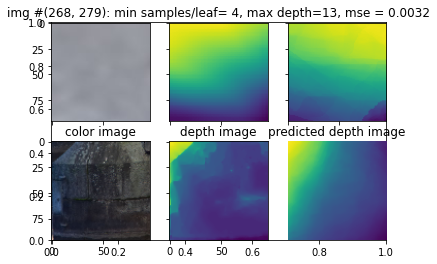

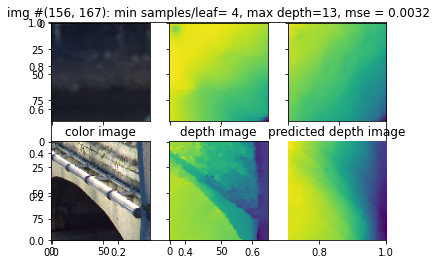

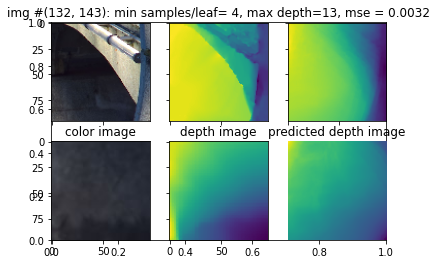

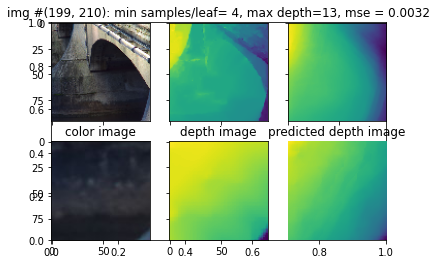

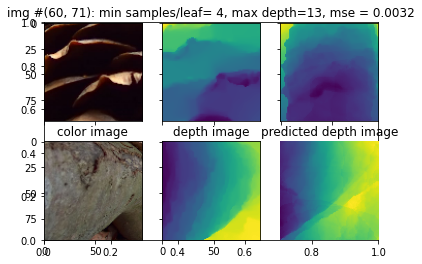

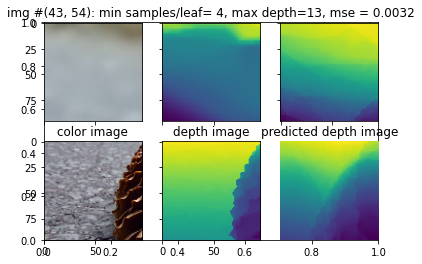

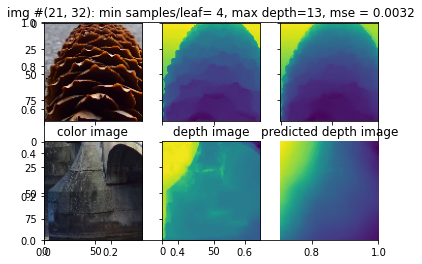

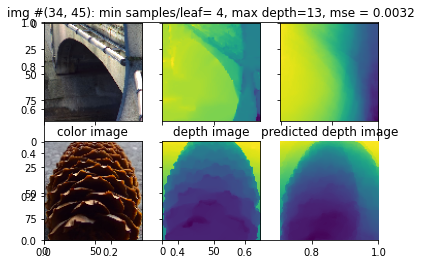

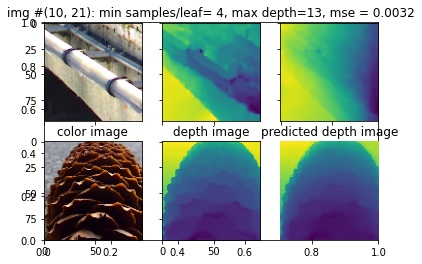

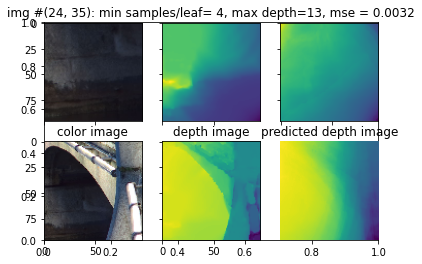

In [9]:
images = [4,59,201,67,42, 212, 268, 156, 132, 199,60,43,21,34,10,24]
for k in images:
    f = plt.figure()
    plt.title(f"img #{k,k+11}: min samples/leaf= 4, max depth=13, mse = {mse :3.2}")
    axarr = f.subplots(2,3)
    plt.axis("off")
    axarr[0,0].imshow(colorimg_test[k])
    axarr[0,1].imshow(y_test[k].reshape(96,96,1))
    axarr[0,2].imshow(y_pred6[k].reshape(96,96,1))
    axarr[1,0].imshow(colorimg_test[k+11])
    axarr[1,1].imshow(y_test[k+11].reshape(96,96,1))
    axarr[1,2].imshow(y_pred6[k+11].reshape(96,96,1))
    axarr[1,0].set_title('color image')
    axarr[1,1].set_title('depth image')
    axarr[1,2].set_title('predicted depth image')
    for ax in axarr.flat:
        ax.label_outer()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 15.0)

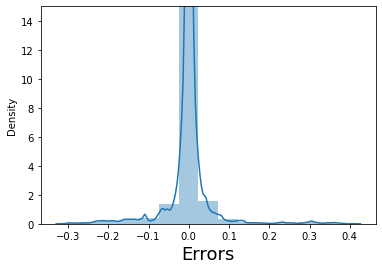

In [11]:
# residuals 
res = y_pred6 - y_test
fig = plt.figure()
sns.distplot(res, bins = 15)                
plt.xlabel('Errors', fontsize = 18) 
plt.ylim(0,15)

<class 'numpy.ndarray'>
residuals shape (280, 9216)

 Residuals summary 
 count    9216.000000
mean        0.010020
std         0.002520
min        -0.001069
25%         0.008916
50%         0.009908
75%         0.010780
max         0.027124
dtype: float64


Text(0, 0.5, 'predicted depth')

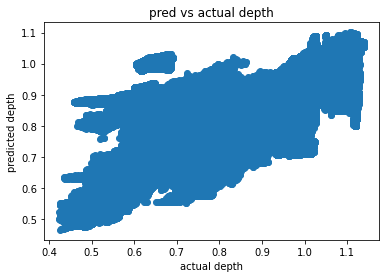

In [13]:
# plot res vs coefs 
print(type(res)) 
print("residuals shape",res.shape)
resi = pd.Series(res[0])

print("\n Residuals summary \n",resi.describe())

fig = plt.figure()
plt.scatter(y_test, y_pred6)
plt.title("pred vs actual depth")
plt.xlabel("actual depth")
plt.ylabel("predicted depth")